In [1]:
import tensorflow as tf
import tensorflow.keras as tfk

from tensorflow.keras.preprocessing import image as tfk_image
from tensorflow.keras.preprocessing.image import ImageDataGenerator as tfk_ImageDataGenerator

import datetime, os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.utils import class_weight

In [2]:
os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'

## Load Pre-trained Models

In [3]:
from tensorflow.keras.applications import Xception as tfk_BaseModel
from tensorflow.keras.applications.xception import preprocess_input as tfk_preprocess_input

In [4]:
yolov3 = tfk.models.load_model('.model_files\saves\yolov3.h5')

## Load Dataset

In [5]:
pd_train = pd.read_csv('shopee-product-detection-dataset/train.csv')
pd_test  = pd.read_csv('shopee-product-detection-dataset/test.csv')

In [6]:
input_shape = (256, 256, 3)
# input_shape = (512, 512, 3)
batch_size=128

In [59]:
train_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input,
    validation_split=0.1,
    #featurewise_center=True,
    #featurewise_std_normalization=True,
    rotation_range=20,
    shear_range=20,
    zoom_range=[0.9, 1.1],
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

train_generator = train_datagen.flow_from_directory(
    'shopee-product-detection-dataset/train/',  # this is where you specify the path to the train data folder
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='training'
)

val_generator = train_datagen.flow_from_directory(
    'shopee-product-detection-dataset/train/',  # this is where you specify the path to the train data folder
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=True,
    subset='validation'
)

Found 94869 images belonging to 42 classes.
Found 10523 images belonging to 42 classes.


In [60]:
test_datagen = tfk_ImageDataGenerator(
    preprocessing_function=tfk_preprocess_input
)

test_generator = test_datagen.flow_from_dataframe(
    pd_test,
    directory='shopee-product-detection-dataset/test/',
    x_col='filename',
    y_col='category',
    target_size=input_shape[:2],
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='raw',
    shuffle=True,
)

Found 12186 validated image filenames.


In [61]:
x, y = next(iter(train_generator))

In [34]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.6

labels = [i for i in range(42)]

In [75]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    
    return self.label
  
  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.get_score

def _sigmoid(x):
  return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
    grid_h, grid_w = netout.shape[:2]
    nb_box = 3
    netout = netout.reshape((grid_h, grid_w, nb_box, -1))
    nb_class = netout.shape[-1] - 5
    boxes = []
    netout[..., :2]  = _sigmoid(netout[..., :2])
    netout[..., 4:]  = _sigmoid(netout[..., 4:])
    netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
    netout[..., 5:] *= netout[..., 5:] > obj_thresh
    
    for i in range(grid_h*grid_w):
        row = i / grid_w
        col = i % grid_w
        for b in range(nb_box):
            # 4th element is objectness score
            objectness = netout[int(row)][int(col)][b][4]
            if(objectness.all() <= obj_thresh): continue
            # first 4 elements are x, y, w, and h
            x, y, w, h = netout[int(row)][int(col)][b][:4]
            x = (col + x) / grid_w # center position, unit: image width
            y = (row + y) / grid_h # center position, unit: image height
            w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
            h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
            # last elements are class probabilities
            classes = netout[int(row)][col][b][5:]
            box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
            boxes.append(box)
    return boxes

In [76]:
def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
    new_w, new_h = net_w, net_h
    for i in range(len(boxes)):
        x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
        y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
        boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
        boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
        boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
        boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

In [77]:
def _interval_overlap(interval_a, interval_b):
    x1, x2 = interval_a
    x3, x4 = interval_b
    if x3 < x1:
        if x4 < x1:
            return 0
        else:
            return min(x2,x4) - x1
    else:
        if x2 < x3:
             return 0
        else:
            return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
    # load the image
    data = plt.imread(filename)
    # plot the image
    plt.imshow(data)
    # get the context for drawing boxes
    ax = plt.gca()
    # plot each box
    for i in range(len(v_boxes)):
        box = v_boxes[i]
        # get coordinates
        y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
        # calculate width and height of the box
        width, height = x2 - x1, y2 - y1
        # create the shape
        rect = Rectangle((x1, y1), width, height, fill=False, color='yellow', linewidth = '2')
        # draw the box
        ax.add_patch(rect)
        # draw text and score in top left corner
        label = "%s (%.3f)" % (v_labels[i], v_scores[i])
        plt.text(x1, y1, label, color='yellow')
    # show the plot
    plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


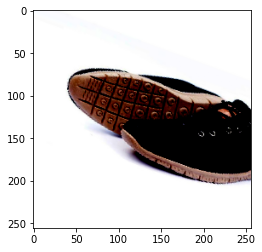

In [96]:
plt.imshow(x[10])

In [97]:
res = yolov3.predict(np.array([x[0]]))

In [98]:
boxes = []
for i in range(3):
    yhat = yolov3.predict(np.array([x[0]]))
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_shape[0], input_shape[1])

In [99]:
#correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)
correct_yolo_boxes(boxes, input_shape[0], input_shape[1], input_shape[0], input_shape[1])

In [100]:
do_nms(boxes, 0.5)

In [101]:
v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

In [102]:
for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])

In [103]:
draw_boxes('imame.png', v_boxes, v_labels, v_scores)

FileNotFoundError: [Errno 2] No such file or directory: 'imame.png'